# Fingerprint

O algoritmo de Fingerprint baseia-se na construção de um banco de referências que armazena amostras representativas dos dados de treinamento. O objetivo principal é reconhecer padrões característicos em regiões específicas.

Quando um novo dado é coletado em um local desconhecido, ele é comparado com as amostras existentes no repositório, permitindo estimar qual delas é mais semelhante ao novo ponto de interesse. Para isso, o algoritmo calcula a distância euclidiana entre os pontos, determinando a similaridade com base na proximidade geométrica dos dados.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
df_bts = pd.read_csv('../inputs/Bts.csv')
df_test_alunos = pd.read_csv('../inputs/meds_test_alunos.csv')
df_train_alunos = pd.read_csv('../inputs/meds_train_alunos.csv')
test_ponto_id = df_test_alunos.pop('ponto_id')
train_ponto_id = df_train_alunos.pop('ponto_id')

Removendo colunas sem nome

In [3]:
df_bts = df_bts.loc[:, ~df_bts.columns.str.contains('^Unnamed')]
df_train_alunos = df_train_alunos.loc[:, ~df_train_alunos.columns.str.contains('^Unnamed')]
df_test_alunos = df_test_alunos.loc[:, ~df_test_alunos.columns.str.contains('^Unnamed')]

Separando as variáveis independentes das dependentes

In [4]:
X = df_train_alunos.drop(columns=['lat', 'lon', 'indoor'])
y = df_train_alunos[['lat', 'lon', 'indoor']]

X_test = df_test_alunos

Dividindo os dados em treinamento e validação

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Haversine

Função que calcula a distância em linha reta entre dois pontos geográficos dados suas latitudes e longitudes, levando em consideração a curvatura da Terra. Essa fórmula é muito útil para aplicativos de geolocalização, como estimativas de distância entre duas cidades ou pontos em mapas.

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000
    return c * r

Distância Euclidiana entre vetores

In [7]:
def euclidean_distance(vector, w_vector):
    return vector_magnitude(subtract_vectors(vector, w_vector))

def vector_magnitude(vector):
   return math.sqrt(square_sum(vector))

def subtract_vectors(vector, w_vector):
    return [v_i - w_i for v_i, w_i in zip(vector, w_vector)]

def square_sum(vector):
    return dot_product(vector, vector)

def dot_product(vector, w_vector):
    return sum(v_i * w_i for v_i, w_i in zip(vector, w_vector))

### Fingerprint

Este método recebe um vetor representando a "impressão digital" de um dispositivo no local de interesse, junto com um DataFrame que contém as impressões digitais de pontos previamente conhecidos. A partir disso, o algoritmo calcula a distância euclidiana entre o vetor atual e cada um dos pontos de referência. Em seguida, os pontos são classificados pela proximidade, e a posição do ponto mais próximo é retornada, com as coordenadas de latitude, longitude e uma indicação sobre se o local está em um ambiente "indoor" (interno) ou não.

In [8]:
def fingerprint(vec, df_ref):
    distancias = []
    for i in range(len(df_ref)):
        distancias.append(euclidean_distance(list(df_ref.iloc[i]), list(vec)))

    df_ref['dist'] = distancias

    df_ref = df_ref.sort_values('dist', ascending=True)

    df_ref = df_ref.reset_index()

    return df_ref.loc[0, ['lat', 'lon', 'indoor']]


Testando fingerprint com um vetor aleatório


In [9]:
v = [106,	122,	114,	123,	130,	111]
df_ = X_train.copy()
df_['lat'] = y_train['lat']
df_['lon'] = y_train['lon']
df_['indoor'] = y_train['indoor']
fingerprint(v,df_)

lat        -8.0542
lon      -34.94651
indoor       False
Name: 0, dtype: object

Aplicando o fingerprint ao conjunto de validação para gerar as previsões de localização

In [10]:
Y_pred = [list(fingerprint(v,df_)) for _,v in X_val.iterrows()]

Criando um novo DataFrame com as predições

In [11]:
df2 = y_val.copy()
df2['lat_pred'] = [lat for lat,_,_ in Y_pred]
df2['lon_pred'] = [lon for _,lon,_ in Y_pred]
df2['indoor'] = [indoor for _,_,indoor in Y_pred]

Calculando o erro de predição (distância entre a localização de validação e a de predição)

In [12]:
distances = haversine(y_val['lat'], y_val['lon'], df2['lat_pred'], df2['lon_pred'])

### Analisando a precisão do modelo com base nas distâncias entre predições e os valores reais de validação

In [13]:
mean_distance = np.mean(distances)
max_distance = np.max(distances)
min_distance = np.min(distances)
std_distance = np.std(distances)

print(f"Mean Distance: {mean_distance:.2f} meters")
print(f"Max Distance: {max_distance:.2f} meters")
print(f"Min Distance: {min_distance:.2f} meters")
print(f"Standard Deviation of Distance: {std_distance:.2f} meters")
distances.describe()

Mean Distance: 22.63 meters
Max Distance: 1292.46 meters
Min Distance: 0.00 meters
Standard Deviation of Distance: 83.70 meters


count    1355.000000
mean       22.630875
std        83.727393
min         0.000000
25%         0.000000
50%         0.000000
75%         8.397823
max      1292.456134
dtype: float64

<Axes: >

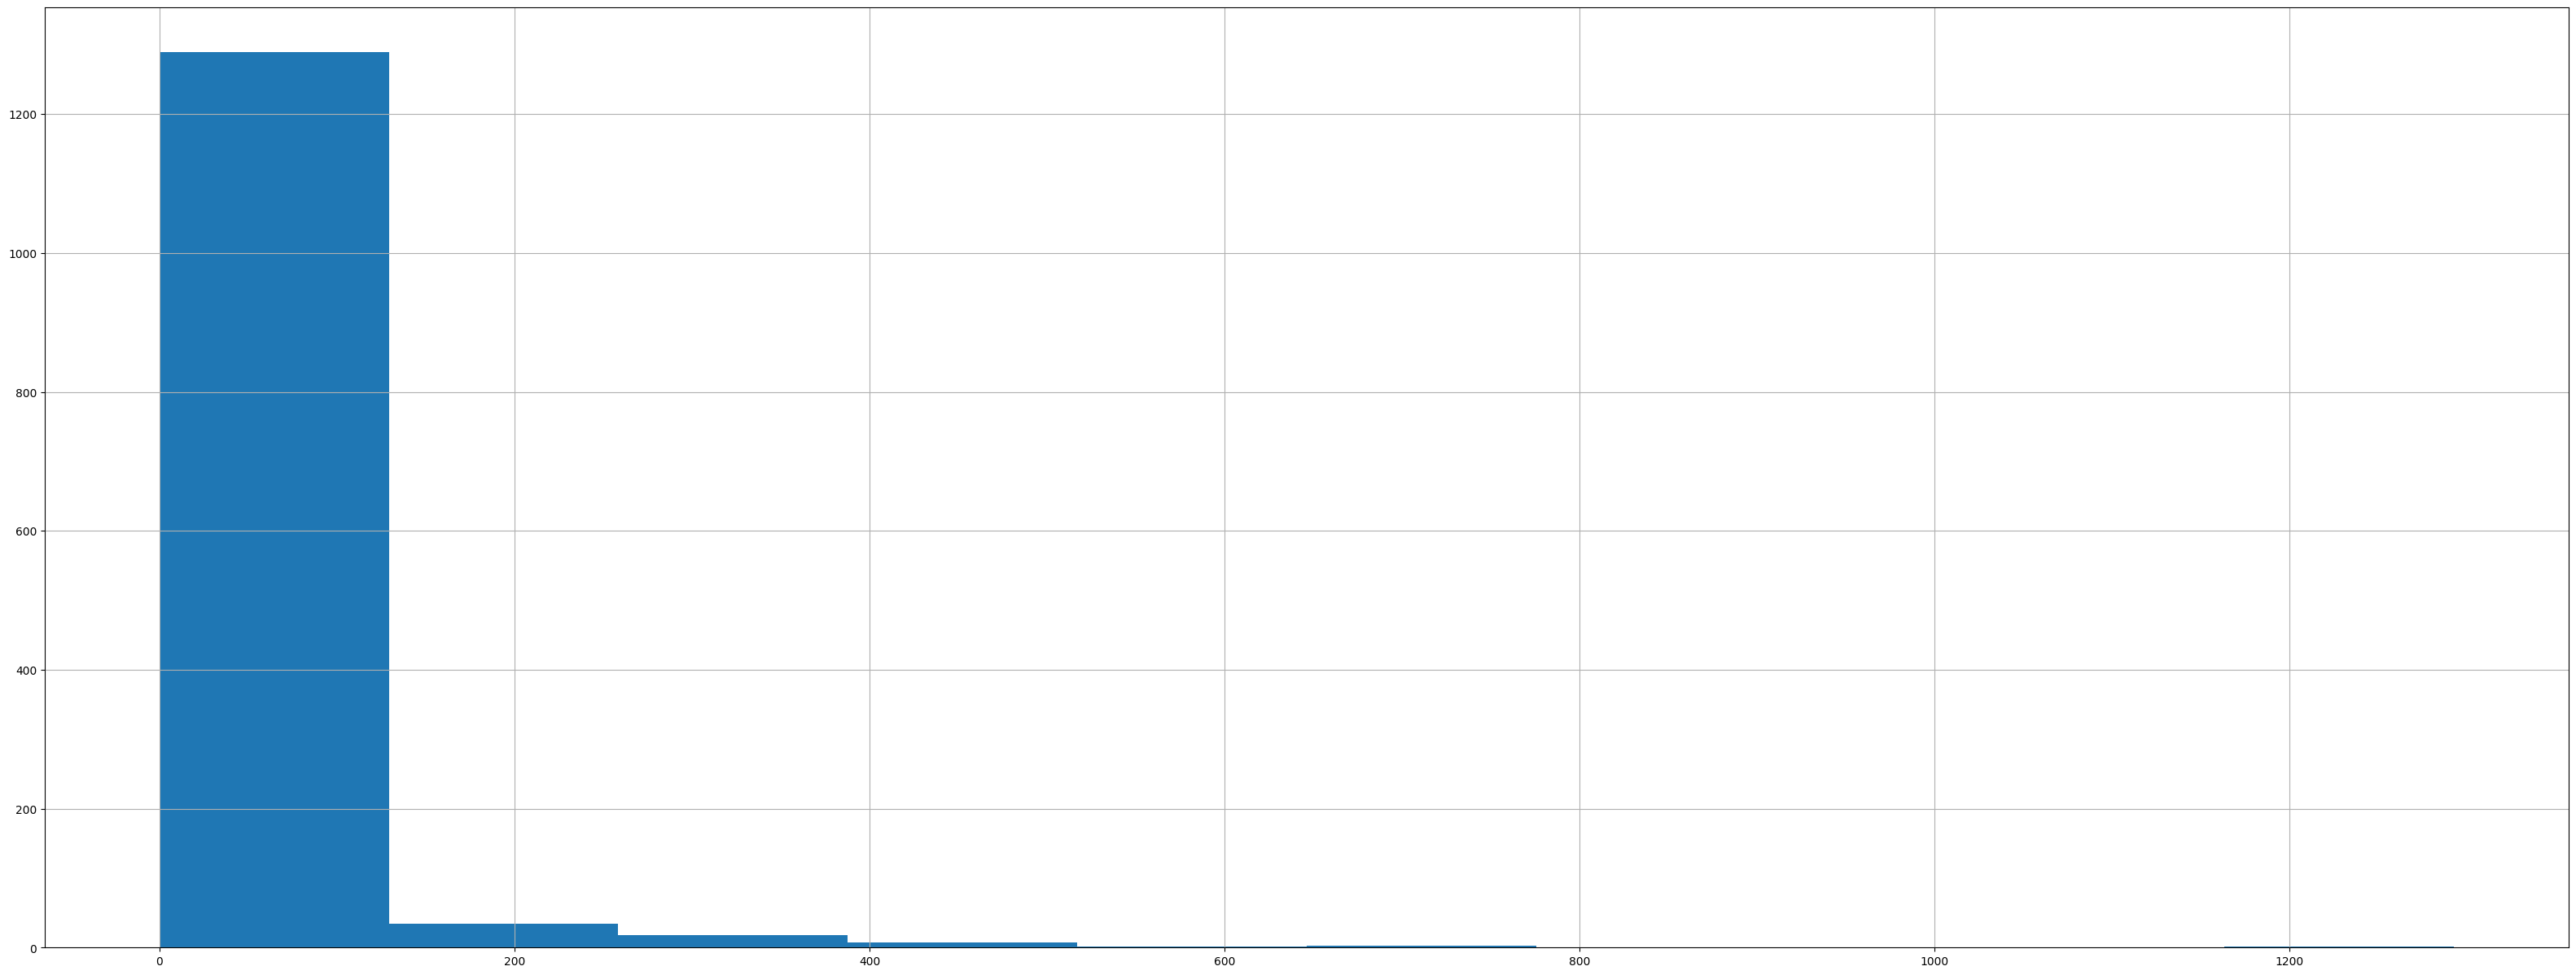

In [14]:
distances.hist(bins=10, figsize=(40,15))

<Axes: >

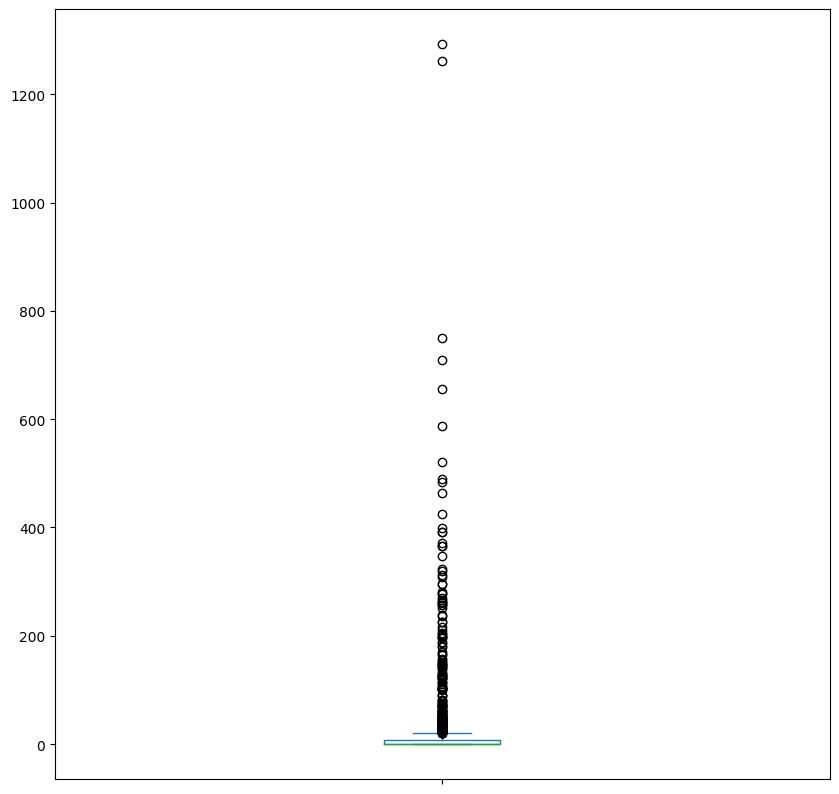

In [15]:
distances.plot(kind='box', figsize=(10,10))

Mapa de comparação: posições preditas x posições reais para banco de validação

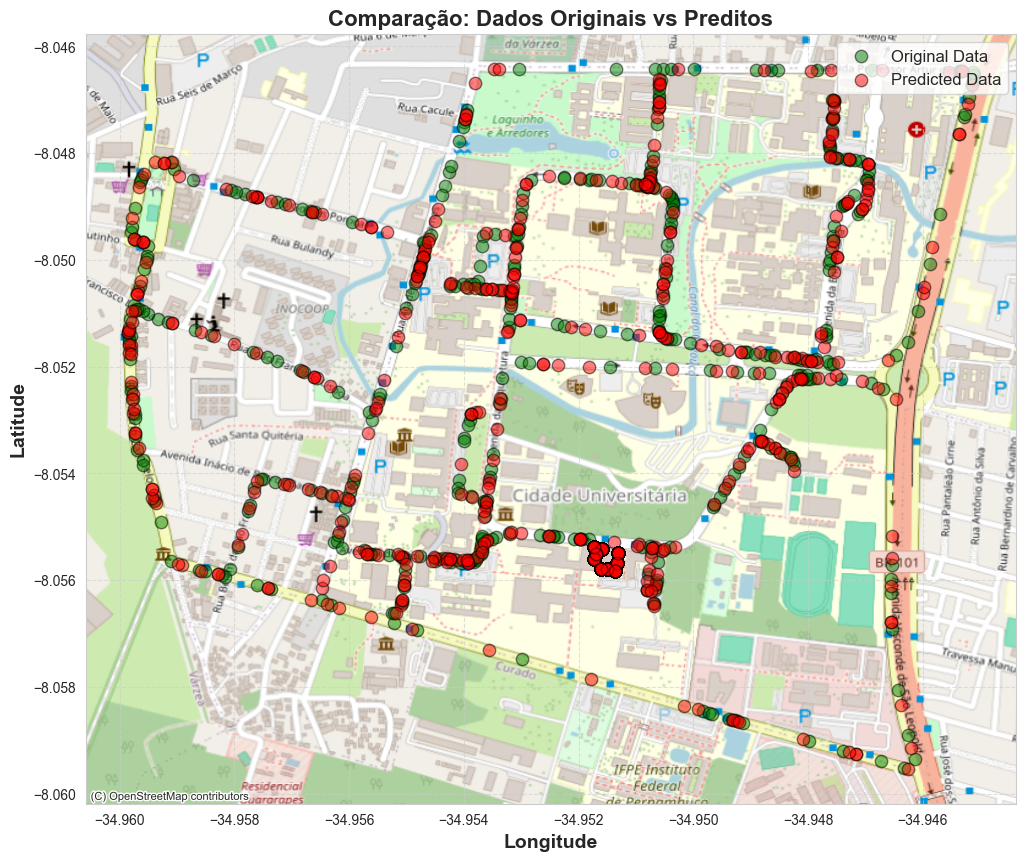

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))

plt.scatter(y_val['lon'], y_val['lat'], 
            color='green', edgecolors='black',
            label='Original Data', alpha=0.5, s=80)

plt.scatter(df2['lon_pred'], df2['lat_pred'], 
            color='red', edgecolors='black',
            label='Predicted Data', alpha=0.5, s=80)

ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.ylabel('Latitude', fontsize=14, fontweight='bold')
plt.title('Comparação: Dados Originais vs Preditos', fontsize=16, fontweight='bold')
plt.legend(frameon=True, fontsize=12, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [19]:
X_test = df_test_alunos
y_test_pred = [list(fingerprint(v,df_)) for _,v in X_test.iterrows()]

In [20]:
df_test_alunos['lat_pred'] = [lat for lat,_,_ in y_test_pred]
df_test_alunos['lon_pred'] = [lon for _,lon,_ in y_test_pred]
df_test_alunos['indoor'] = [indoor for _,_,indoor in y_test_pred]

Mapa com as predições para o conjunto de teste

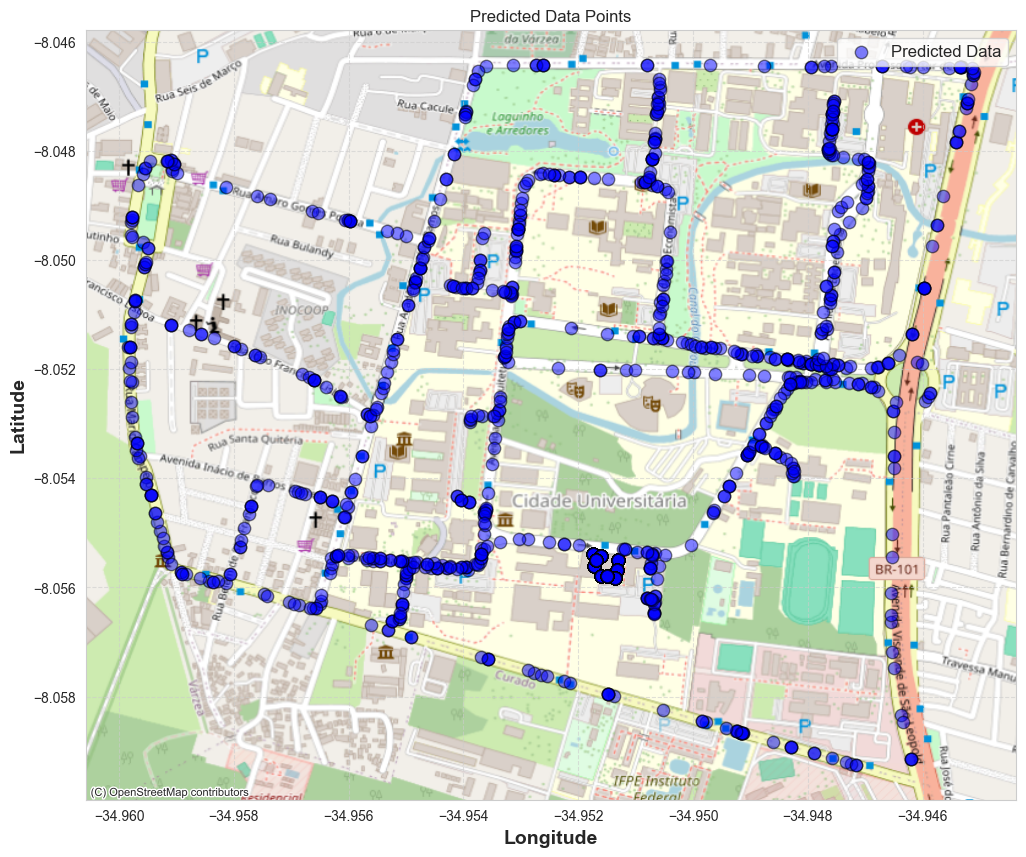

In [24]:
plt.figure(figsize=(12, 10))
plt.scatter(df_test_alunos['lon_pred'], df_test_alunos['lat_pred'], 
            color='blue', edgecolors='black',
            label='Predicted Data', alpha=0.5, s=80)

ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.ylabel('Latitude', fontsize=14, fontweight='bold')
plt.title('Predicted Data Points')
plt.legend(frameon=True, fontsize=12, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Visualizando as predições indoors e outdoors

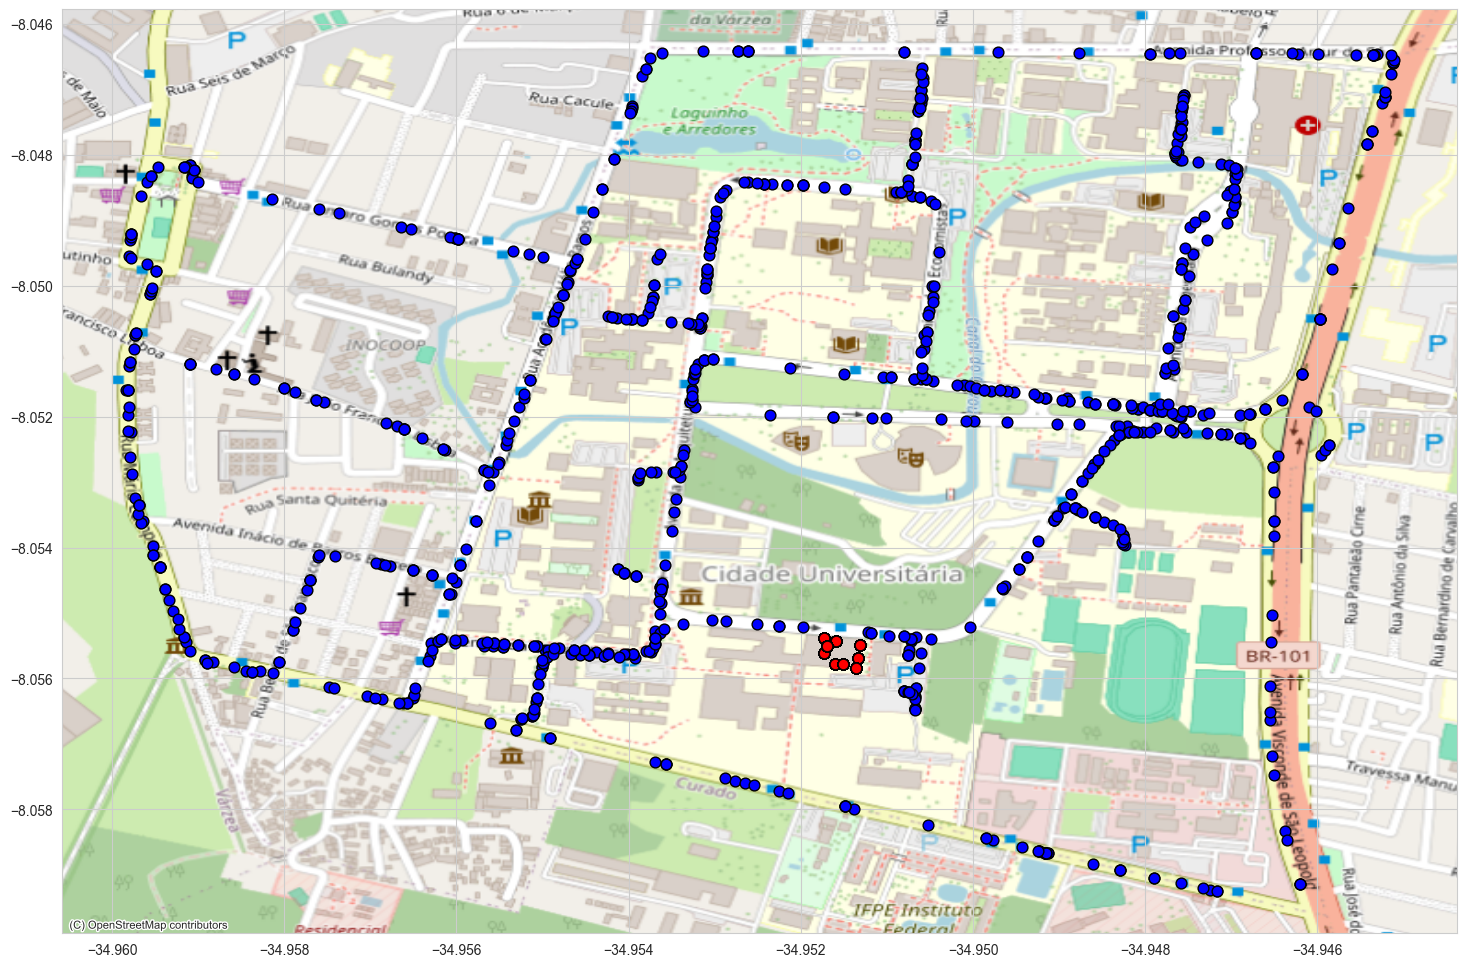

In [27]:
fig, subs = plt.subplots()

df_test_indoors = df_test_alunos[df_test_alunos['indoor'] == True]
df_test_indoors

df_test_outdoors = df_test_alunos[df_test_alunos['indoor'] == False]
df_test_outdoors

subs.scatter(df_test_indoors['lon_pred'], df_test_indoors['lat_pred'], 
            color='red', edgecolors='black', s = 60)


subs.scatter(df_test_outdoors['lon_pred'], df_test_outdoors['lat_pred'], 
            color='blue', edgecolors='black', s = 60)


ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

plt.gcf().set_size_inches((18,12))
plt.show()

Visualizando como os atrasos se distribuem e se correlacionam com a localização

In [28]:
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
df_test_alunos['delay_1_norm'] = norm(df_test_alunos['delay_1'])
df_test_alunos['delay_2_norm'] = norm(df_test_alunos['delay_2'])
df_test_alunos['delay_3_norm'] = norm(df_test_alunos['delay_3'])
df_test_alunos['color'] = df_test_alunos.apply(lambda row: (row['delay_1_norm'], row['delay_2_norm'], row['delay_3_norm']), axis=1)

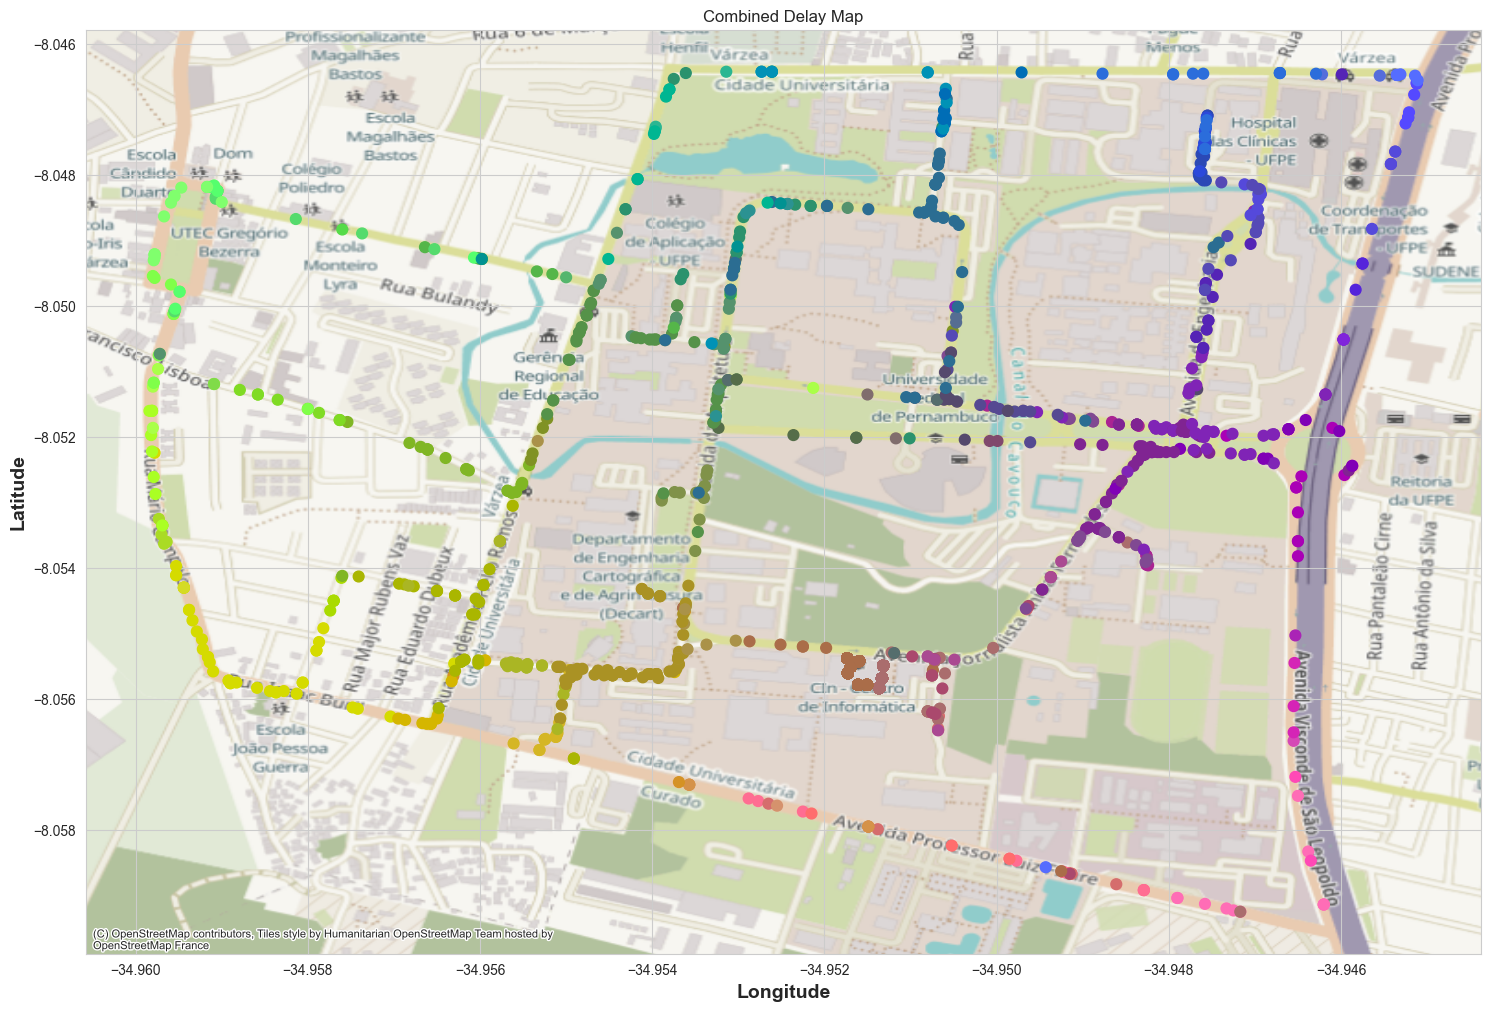

In [30]:
plt.scatter(df_test_alunos['lon_pred'], df_test_alunos['lat_pred'], color= df_test_alunos['color'], s=60)

ctx.add_basemap(plt.gca(), crs='EPSG:4326')

plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.ylabel('Latitude', fontsize=14, fontweight='bold')
plt.title('Combined Delay Map')

plt.gcf().set_size_inches((18,12))
plt.show()

In [31]:
df_test_alunos['ponto_id'] = test_ponto_id
df_result = df_test_alunos[['ponto_id', 'lat_pred', 'lon_pred', 'indoor']]
df_result.to_csv('../results/Resultados_Equipe1_Metodo_Fingerprint.csv')